# Simple cuProj WGS84 to UTM Projection Benchmark

This notebook is a simple benchmark of the cuProj library. It compares the performance of the cuProj library to the performance of the [PyProj]https://pyproj4.github.io/pyproj/stable/index.html) library. The benchmark is performed on a single GPU and a single CPU, respectively.

## Imports and setup

In [1]:
import numpy as np
import cupy as cp
from cuda import cudart

from pyproj import Transformer
from cuproj import Transformer as cuTransformer

import timeit

import matplotlib.pyplot as plt

KeyboardInterrupt: 

The benchmark is performed on a 2D grid of (latitude, longitude) points in the WGS84 (EPSG 4326) coordinate reference system (CRS), transforming them to UTM Zone 10N (EPSG 32610) . The grid is defined around San Francisco, California, USA.

In [ ]:
# San Francisco bounding box
min_corner = (37.7081, -122.5149)
max_corner = (37.8324, -122.3573)
crs_from = "EPSG:4326"
crs_to = "EPSG:32610"

The following functions generate a grid and transform all the points on the grid from WGS84 to UTM.
There are two versions of the cuProj benchmark: one uses a Cupy ndarray stored in device memory and the other a Numpy ndarray stored in host memory. The latter includes the cost to copy the data from host to device memory, while the former times only the GPU computation.

In [ ]:
def run_pyproj(num_points):
    grid_side = int(np.sqrt(num_points))
    transformer = Transformer.from_crs(crs_from, crs_to)

    x, y = np.meshgrid(np.linspace(min_corner[0], max_corner[0], grid_side),
                       np.linspace(min_corner[1], max_corner[1], grid_side))

    grid = [x.reshape(-1), y.reshape(-1)]

    # warmup
    transformer.transform(*grid)

    t = timeit.Timer(lambda: transformer.transform(*grid))
    return t.autorange()

def cu_run_and_sync(transformer, grid):
  transformer.transform(*grid)
  cudart.cudaDeviceSynchronize()

def run_cuproj(num_points):
    grid_side = int(np.sqrt(num_points))
    transformer = cuTransformer.from_crs(crs_from, crs_to)

    x, y = cp.meshgrid(cp.linspace(min_corner[0], max_corner[0], grid_side),
                       cp.linspace(min_corner[1], max_corner[1], grid_side))

    grid = [x.reshape(-1), y.reshape(-1)]

    # warmup
    cu_run_and_sync(transformer, grid)

    t = timeit.Timer(lambda: cu_run_and_sync(transformer, grid))
    return t.autorange()

def run_cuproj_host_data(num_points):
    grid_side = int(np.sqrt(num_points))
    transformer = cuTransformer.from_crs(crs_from, crs_to)

    x, y = np.meshgrid(np.linspace(min_corner[0], max_corner[0], grid_side),
                       np.linspace(min_corner[1], max_corner[1], grid_side))

    grid = [x.reshape(-1), y.reshape(-1)]

    # warmup
    cu_run_and_sync(transformer, grid)

    t = timeit.Timer(lambda: cu_run_and_sync(transformer, grid))
    return t.autorange()

## Run Benchmarks

Run each benchmark and compute the throughput in points per second.

In [ ]:
min_points = 100
max_points = 1e9 
num_points = np.geomspace(min_points, max_points, 8).astype(int)

throughput_pyproj = []
throughput_cuproj = []
throughput_cuproj_host_data = []

# pyproj
for n in num_points:
    iters, time = run_pyproj(n)
    throughput_pyproj.append(n / (time / iters))
    
# cuproj data on device
for n in num_points:
    iters, time = run_cuproj(n)
    throughput_cuproj.append(n / (time / iters))

# cuproj including host to device copy
for n in num_points:
    iters, time = run_cuproj_host_data(n)
    throughput_cuproj_host_data.append(n / (time / iters))

KeyboardInterrupt: 

## Results

Plot the results using matplotlib.

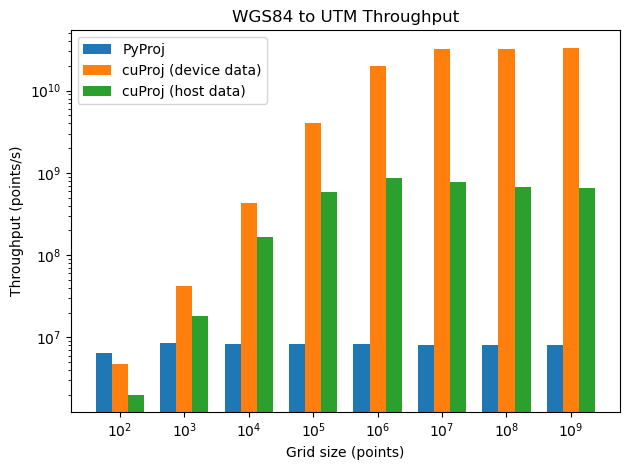

In [ ]:
mean_throughputs = {'PyProj': throughput_pyproj, 
          'cuProj (device data)': throughput_cuproj,
          'cuProj (host data)': throughput_cuproj_host_data}

x = np.arange(len(num_points))
width = 0.25

fig, ax = plt.subplots()

ax.set_yscale('log')
ax.set_ylabel('Throughput (points/s)')
ax.set_xlabel('Grid size (points)')
ax.set_title('WGS84 to UTM Throughput')
ax.set_xticks(x)

import locale
locale.setlocale(locale.LC_ALL, '')  # set the locale to the user's default

powers = [int(np.log10(n)) for n in num_points]
ax.set_xticklabels([f'$10^{n}$' for n in powers])

for i, label in enumerate(mean_throughputs.keys()):
  rects = ax.bar(x + (i - 1) * width, mean_throughputs[label], width, label=label)

ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# display a data table of the mean throughputs
# for each of the 3 methods
df = pd.DataFrame(mean_throughputs, index=num_points)
df.index.name = 'Grid size (points)'
df.columns.name = 'Method'
df

Method,PyProj,cuProj (device data),cuProj (host data)
Grid size (points),,,
100,6.456583e+06,4.767634e+06,2.009619e+06
1000,8.490731e+06,4.249830e+07,1.838139e+07
10000,8.415854e+06,4.249423e+08,1.640383e+08
100000,8.414452e+06,4.053401e+09,5.901236e+08
1000000,8.379849e+06,1.988196e+10,8.654184e+08
10000000,8.180662e+06,3.182774e+10,7.743423e+08
100000000,8.186607e+06,3.167794e+10,6.646177e+08
1000000000,8.189200e+06,3.327126e+10,6.528686e+08


In [ ]:
# compute peak speedup
n = format(num_points[-1], ',')
print(f"cuProj Speedup for {n} points: {mean_throughputs['cuProj (device data)'][-1] / mean_throughputs['PyProj'][-1] :.2f}x")


cuProj Speedup for 1,000,000,000 points: 4062.82x
